# Understanding Metrics of Classification  
Sayan Rakshit
<br>
<a href="https://github.com/sayan10rakshit/">GitHub</a>

In this notebook, lets make a clear understanding of the different metrics used to determine the performance of any classifier. We will calculate different metrics and see what it represents.   
We will calculate these metrics by defining our own functions, and also verify them by comparing with `scikit-learn's` library functions.   

Lets start with importing libraries we will need in this notebook.

### Importing libraries

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

np.random.seed(42)  # for reproducibility
sns.set(rc={"figure.figsize": (8, 8)})
sns.set_style("ticks")

### Dataset
For comparing different metrics, we will use the [Breast Cancer Dataset](https://goo.gl/U2Uwz2) which is provided by sckit-learn in `dataset` module. This dataset is used for binary classification between two types of cancer.

In [6]:
data = load_breast_cancer()
print(data.DESCR[:760])  # print short description

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline appr


Let's see what are the targets classes i.e. types of cancer.

In [7]:
print(f"Types of cancer (targets) are {data.target_names}")

Types of cancer (targets) are ['malignant' 'benign']


What is the dimension of data?  We see there are **569 examples** and each example has **30 features**.  
The **target** variable is binary (**0 and 1** for `malignant` and `benign`).   
We will consider `benign` as `positive` class, and `malignant` as `negative` class.  
We can understand it as:  
`0 for is_not_benign`  
`1 for is_benign`

In [8]:
X = data.data  # features
y = data.target  # labels
print(f"Shape of features is {X.shape}, and shape of target is {y.shape}")

Shape of features is (569, 30), and shape of target is (569,)


### Split the data
Since we shouldn't train and test our model with the same dataset, it is always a good idea to split the data in three parts - train data, test data, and validation data.  
We won't require validation data here.
We split the dataset into training and testing data, with 369 examples for training, and 200 examples for testing.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42, stratify=y)

In [10]:
y_train[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

### Training and predicting data

In this example, we will use scikit's Support Vector Machines classifier to predict whether its a benign cancer.  
`SVC` classifier is used from `sklearn.svm`. Ofcourse, we can try any of the other classifiers and compare accuracies.

In [11]:
classifier = svm.SVC(kernel='linear', probability=True, verbose=True)

Next we fit/train the model on our _training dataset_. It trains quite fast since we are working with relatively small dataset.

In [12]:
classifier.fit(X_train, y_train)

[LibSVM]

SVC(kernel='linear', probability=True, verbose=True)

Now save the prediction results both as probability and as classes.  
**`y_preds`** is a **1D vector** of one of `{0, 1}` values, denoting predictions as malignant and benign, respectively.  
**`y_proba`** is a **2D vector**, where for each example, it contains a vector of length 2,  
`[prob. of malignant, prob. of benign]`

In [13]:
y_preds = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)

We need to reshape `y_proba` to a 1D vector denoting the probability of having  `benign` cancer.

In [14]:
y_proba = y_proba[:,1].reshape((y_proba.shape[0],))

In [15]:
y_proba[:5], y_preds[:5], y_test[:5]

(array([0.99697265, 0.08136592, 0.99999168, 0.96809404, 0.99999907]),
 array([1, 0, 1, 1, 1]),
 array([1, 0, 1, 1, 1]))

### Confusion Matrix

Let us calculate confusion matrix of the predictions. It is implemented in Scikit-learn's [`sklearn.metrics.confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [16]:
conf = metrics.confusion_matrix(y_test, y_preds)
conf

array([[ 68,   7],
       [  2, 123]], dtype=int64)

We can also implement our own confusion matrix.  Here's my implementation.

In [17]:
def get_confusion_matrix(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [ ]:
conf = get_confusion_matrix(y_test, y_preds)
conf

array([[ 68,   7],
       [  2, 123]])

Text(0.5,83.88,'Predicted label')

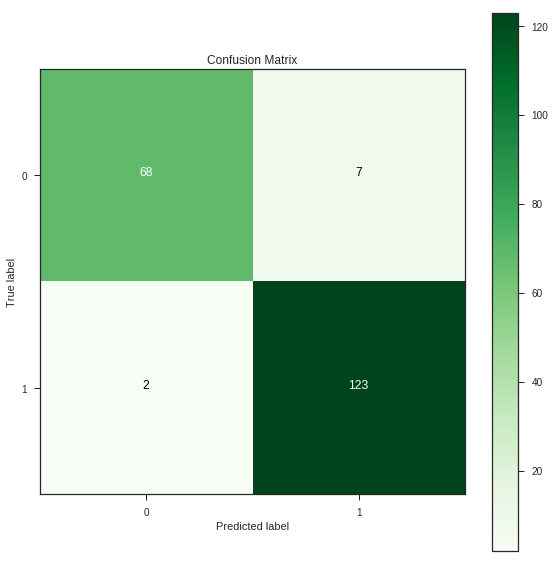

In [ ]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

From the confusion matrix, we can see the number of examples predicted correct by our classifier, for both classes seperately.  
We can get the numbers of `True Positives, True Negatives, False Positives, and False Negatives` from this confusion matrix.   
Lets store these terms in some variables.

In [18]:
# from the confusion matrix
TP = true_pos = 123
TN = true_neg = 68
FP = false_pos = 7
FN = false_neg = 2

### Some basic metrics

Now, we will calculate some basic metrics from these four values.  
We will need a dictionary to store these metrics. Lets create a dictionary `results`.

In [19]:
results = {}

#### Accuracy 
number of examples correctly predicted / total number of examples  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/c72ec21ef2505c2d376e96197637fc64f75e5891)

In [20]:
metric = "ACC"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

ACC is  0.955


#### True Positive Rate
number of samples actually and predicted as  `Positive` / total number of samples actually `Positive`  
Also called **Sensitivity or Recall**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/64d5540cbadeb83f864d7a731b7ab43cccd0f353)


In [21]:
# Sensitivity or Recall
metric = "TPR"
results[metric] = TP / (TP + FN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  0.984


#### True Negative Rate
number of samples actually and predicted as  `Negative` / total number of samples actually  `Negative`  
Also called **Specificity**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/aac65b6586cb61c1268403895012c2a8f19b0c5e)


In [22]:
# Specificity
metric = "TNR"
results[metric] = TN / (TN + FP)
print(f"{metric} is {results[metric]: .3f}")

TNR is  0.907


#### Positive Predictive Value
number of samples actually and predicted as  `Positive` / total number of samples predicted as `Positive`  
Also called **Precision**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/699fcdb880b7f6a92742bc0845b8b60b59806a98)


In [23]:
# Precision
metric = "PPV"
results[metric] = TP / (TP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  0.946


#### Negative Predictive Value
number of samples actually and predicted as  `Negative` / total number of samples predicted as `Negative`    
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/b6da0f59faffbc1704974e97847ab4fa599f5521)


In [24]:
metric = "NPV"
results[metric] = TN / (TN + FN)
print(f"{metric} is {results[metric]: .3f}")

NPV is  0.971


#### F1 score
Harmonic Mean of Precision and Recall.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5663ca95d471868169c4e4ea57c936f1b6f4a588)

In [25]:
metric = "F1"
results[metric] = 2 / (1 / results["PPV"] + 1 / results["TPR"])
print(f"{metric} is {results[metric]: .3f}")

F1 is  0.965


#### Matthew's correlation coefficient
Matthew's coefficient range between `[-1, 1]`. `0` usually means totally random predictions. `1` means a perfect classifier, while a negative value (`[-1, 0)`) suggests a negative correlation between predictions and actual values.   
Here' the formual for MCC  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

In [26]:
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
results[metric] = num / den
print(f"{metric} is {results[metric]: .3f}")

MCC is  0.904


### Comparing these calculated metrics
Let's check if these values match with the values calculated from `scikit-learn`'s functions.

In [27]:
print(f"Calculated and Actual Accuracy:                          {results['ACC']: .3f}, {metrics.accuracy_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual Precision score:                   {results['PPV']: .3f}, {metrics.precision_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual Recall score:                      {results['TPR']: .3f}, {metrics.recall_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual F1 score:                          {results['F1']: .3f}, {metrics.f1_score(y_test, y_preds): .3f}")
print(f"Calculated and Actual Matthew's correlation coefficient: {results['MCC']: .3f}, {metrics.matthews_corrcoef(y_test, y_preds): .3f}")

Calculated and Actual Accuracy:                           0.955,  0.955
Calculated and Actual Precision score:                    0.946,  0.946
Calculated and Actual Recall score:                       0.984,  0.984
Calculated and Actual F1 score:                           0.965,  0.965
Calculated and Actual Matthew's correlation coefficient:  0.904,  0.904


### ROC curve (Receiver Operating Characteristic curve)
 A receiver operating characteristic curve, i.e. **ROC curve**, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.  
 The ROC curve is created by plotting the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings.  
 Let's plot the ROC curve for the Breast Cancer Dataset.  
 
 First we will create an ROC curve by calculating values manually at intervaled **thresholds**, then we will compare our results with the `scikit-learn`'s built-in `metrics.roc_curve`.

In [28]:
def get_roc_curve(y_test, y_proba, delta=0.1):
    """
    Return the True Positive Rates (TPRs), False Positive Rates (FPRs), 
    and the threshold values, seperated by delta.
    """
    thresh = list(np.arange(0, 1, delta)) + [1]
    TPRs = []
    FPRs = []
    y_pred = np.empty(y_proba.shape)
    for th in thresh:
        y_pred[y_proba < th] = 0
        y_pred[y_proba >= th] = 1
        
        # confusion matrix from the function we defined
        (TN, FP), (FN, TP) = get_confusion_matrix(y_test, y_pred)
        
        TPR = TP / (TP + FN)  # sensitivity
        FPR = FP / (FP + TN)  # 1 - specificity
        TPRs.append(TPR)
        FPRs.append(FPR)
    return FPRs, TPRs, thresh

Here, `delta` is the difference between each of the thresholds at which ROC curve is calculated.

In [29]:
delta = 0.001
FPRs, TPRs, _ = get_roc_curve(y_test, y_proba, delta)

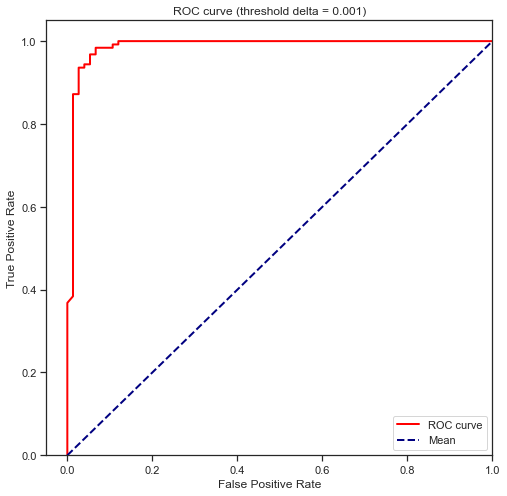

In [30]:
# Plot the ROC curve
plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (threshold delta = {delta})')
plt.legend(loc="lower right")
plt.show()

The peak towards left-most corner means near perfect classifier, while random prediction will have the curve as the blue dotted straight line.  
This ROC curve tells us that our model is nearly perfect classifier, with high accuracy :)

Let's calculate an ROC curve with random predictions, and plot it to see the difference.

In [31]:
# create random predictions
rand_proba = np.random.random(size=(y_proba.shape))
rand_proba[:5]  # 0.5 probability of being 0 or 1

array([0.79654299, 0.18343479, 0.779691  , 0.59685016, 0.44583275])

In [32]:
FPRs, TPRs, _ = get_roc_curve(y_test, rand_proba, delta)  # passing random preds

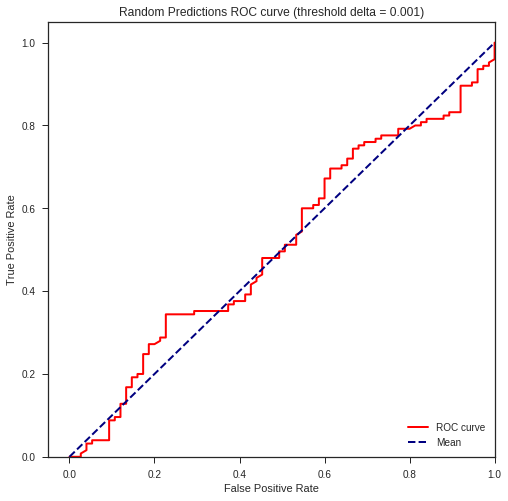

In [ ]:
# Plot the ROC curve
plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Random Predictions ROC curve (threshold delta = {delta})')
plt.legend(loc="lower right")
plt.show()

As we can see from the above plot, random predictions give the ROC curve nearly at the mean.  
Contrast it with the previous curve, how our model has top left peak, due to its superior performance.

---
Now, let's see how these curve's are similiar to the ROC curve with scikit's implementation.

In [33]:
FPRs, TPRs, _ = metrics.roc_curve(y_test, y_proba)

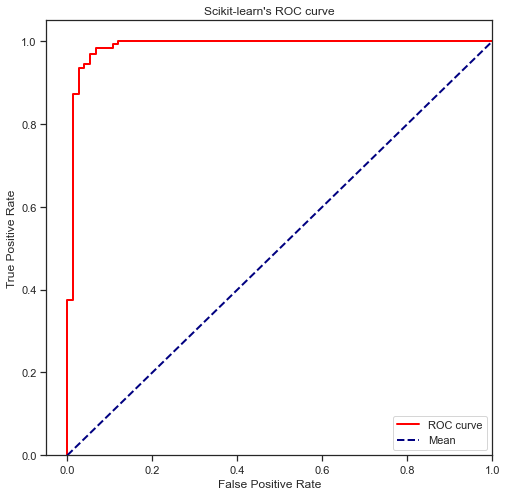

In [34]:
# Plot the ROC curve
plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Scikit-learn's ROC curve")
plt.legend(loc="lower right")
plt.show()

In [35]:
FPRs, TPRs, _ = metrics.roc_curve(y_test, rand_proba)  # passing random preds

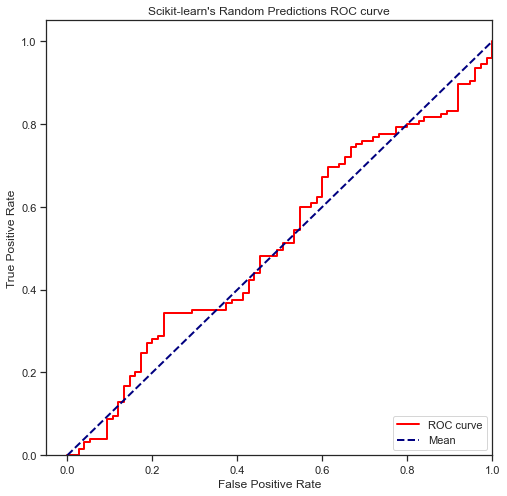

In [36]:
# Plot the ROC curve
plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Scikit-learn's Random Predictions ROC curve")
plt.legend(loc="lower right")
plt.show()

### ROC-AUC score
Now, that we know about ROC curve, what it represents, **AUC score** is very easy to understand.  
AUC stands for **Area under the Curve**, which is nothing but the area under the ROC curve formed by the predictions.  
As we saw, a totally random prediction will have AUC score `0.5`, while a perfect classifier will have AUC score of `1`. 

Lets check the AUC score of our model.

In [37]:
auc_score = metrics.roc_auc_score(y_test, y_proba)
print(f"Scikit's ROC-AUC score of SVC model is {auc_score: .4f}")

Scikit's ROC-AUC score of SVC model is  0.9872


We can also calculate the **ROC-AUC score** by summing up the areas under each observation of FPRs and TPRs.

In [38]:
def get_roc_auc_score(y_test, y_proba):
    
    # use the function get_roc_curve that we created.
    FPRs, TPRs, _ = get_roc_curve(y_test, y_proba)
    FPRs.reverse()
    TPRs.reverse()
    x1, y1 = FPRs[0], TPRs[0]
    auc = 0.0
    prev = 0.0
    # cumulative differences in x-axis
    diffs = [FPRs[i] - FPRs[i-1] for i in range(1, len(FPRs))]
    for x, y in zip(diffs, TPRs[1:]):
        auc += (x * y1)  # area of rectangle
        auc += (x * (y - y1)/2)  # area of triangle formed (if any)
        y1 = y
    return auc

In [39]:
auc_score = get_roc_auc_score(y_test, y_proba)
print(f"Our ROC-AUC score of SVC model is {auc_score: .4f}")

Our ROC-AUC score of SVC model is  0.9874


This is a good ROC-AUC score as we expected. (Also pretty close to Scikit's implementation).  
Lets try the ROC-AUC score of random predictions.

In [40]:
auc_score = metrics.roc_auc_score(y_test, rand_proba)
print(f"Scikit's ROC-AUC score of random predictions is: {auc_score: .4f}")
auc_score = get_roc_auc_score(y_test, rand_proba)
print(f"Our ROC-AUC score of random predictions is:      {auc_score: .4f}")

Scikit's ROC-AUC score of random predictions is:  0.5111
Our ROC-AUC score of random predictions is:       0.5080


As expected, it is close to `0.5`.  
(The minor differences are due to different granularity of thresholds chosen by us, and in Scikit's implementation. )